# Deep Convolution Generative Advarsarial Network

Here is presented the implementation of the following parper https://arxiv.org/abs/1511.06434

Implementation is done in tensorflow using layers API

Created by: Tiago Almeida 05/02/2018


In [1]:
##### imports
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import utils as ut # auxiliar file to help in data visualization

#tensorflow version when notebook was created - 1.4.0
tf.__version__


'1.4.0'

### Data mnist

Extracting ./data\train-images-idx3-ubyte.gz
Extracting ./data\train-labels-idx1-ubyte.gz
Extracting ./data\t10k-images-idx3-ubyte.gz
Extracting ./data\t10k-labels-idx1-ubyte.gz


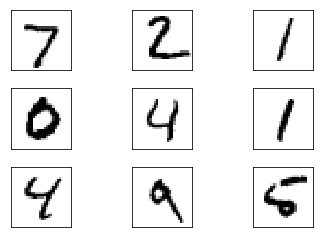

In [2]:


mnist_flat_size = 784

#mnist data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./data",one_hot=True)

ut.plot_mnist_images(mnist.test.images[0:9])

### Code parameters

For the architecture of the generator and the discriminator i am gonna try keep loyal to the network on the paper.



In [3]:
z_dimention = 100
mnist_flat_size = 784

batch_size = 32
epoach = 50000

### Generator network

* 2 Deconvolution layers
* No pooling layers
* Batch normalization after convolution and before activation
* Leaky relu (alpha 0.2 tensorflow default) and tanh for output 

Note: I want that my final image have dimention $28 = 7\times2\times2$, so i can start with 7x7 image and upscale it by deconvolutions operations (with stride 2x2 and padding the image with zeros) the result would be a image with 14x14 and doing the same upscaling i get the final image with the size 28x28 (same as mnist :D)

In [4]:


Z = tf.placeholder(tf.float32, shape=[None, z_dimention], name='x_generator_input')
Y = tf.placeholder(tf.float32, shape=[None, 10], name='label_oneHot')
isTraining = tf.placeholder_with_default(False, shape=(), name='trainingPhase')

def generator(x,train,name):
    '''
    Generator implemented as MLP
    
    :param x: tensor with shape (M,100) here M = number of samples
    :param train: boolean tensor with indication if we are training or not
    :return: tensor with shape (M,28,28,1) corresponding to the image (28x28) mapping between x and data distribution (pData)
    '''
    with tf.variable_scope("generator",reuse=tf.AUTO_REUSE):
        
        # 1 fully connected layer to get 7x7x64 output (3136)
        fc1 = tf.layers.dense(x, 7*7*64,name="fc1_"+name)
        fc1_bn = tf.layers.batch_normalization(fc1, training=train, name="fc1_bn_"+name)
        fc_lrelu1 = tf.nn.leaky_relu(fc1_bn,name="fc1_fn_"+name)
        
        #reshape
        r = tf.reshape(fc_lrelu1, [-1, 7, 7, 64])
        
        # 1 deconv 64 filters output 14x14x32
        deconv1 = tf.layers.conv2d_transpose(r, 64, kernel_size=(5, 5), strides=(2, 2)
                                             ,padding='same',name="dconv1_"+name)
        deconv1_bn = tf.layers.batch_normalization(deconv1, training=train,name="dconv1_bn_"+name)
        dc_lrelu2 = tf.nn.leaky_relu(deconv1_bn,name="dconv1_fn_"+name)

        # 2 deconv 1 filters and output 28x28x1
        deconv2 = tf.layers.conv2d_transpose(dc_lrelu2, 1, kernel_size=(5, 5), strides=(2, 2),padding='same'
                                             ,name="dconv2_"+name, activation=tf.nn.tanh)

        return deconv2



### Discriminator Network

In [5]:

X = tf.placeholder(tf.float32, shape=[None, mnist_flat_size], name='x_discriminator_input')

def discriminator(x,train,name,drop_rate=0.5):
    '''
    Discriminator implemented as MLP
    
    :param x: tensor with shape (M,784) here M = number of samples
    :return: tensor with shape (M,1) corresponding to the probability of each sample being true or fake
    '''
    with tf.variable_scope("discriminator",reuse=tf.AUTO_REUSE):
        
        #reshape
        r = tf.reshape(x, [-1, 28, 28, 1])
        
        # 1 conv 64 filters output 14x14x32
        conv1 = tf.layers.conv2d(r, 64, kernel_size=(5, 5), strides=(2, 2)
                                             ,padding='same',name="conv1_"+name)
        conv1_bn = tf.layers.batch_normalization(conv1, training=train, name="conv1_bn_"+name)
        c_relu1 = tf.nn.relu(conv1_bn,name="conv1_fn_"+name)
        
        # 2 conv 32 filters and output 7x7x32
        conv2 = tf.layers.conv2d(c_relu1, 32, kernel_size=(5, 5), strides=(2, 2),padding='same'
                                             ,name="conv2_"+name, activation=tf.nn.tanh)
        conv2_bn = tf.layers.batch_normalization(conv2, training=train, name="conv2_bn_"+name)
        c_relu2 = tf.nn.relu(conv2_bn, name="conv2_fn_"+name)
        
        #flatten
        flatten = tf.layers.flatten(c_relu2)
        
        fc1 = tf.layers.dense(flatten, 7*7*32,name="fc1_"+name,activation=tf.nn.relu)
        fc1_drop = tf.layers.dropout(fc1,rate = drop_rate, training=train)
        
        fc2 = tf.layers.dense(fc1_drop, 256,name="fc2_"+name,activation=tf.nn.relu)
        fc2_drop = tf.layers.dropout(fc2,rate = drop_rate, training=train)
        
        fc3 = tf.layers.dense(fc2_drop, 1,name="fc3_"+name, activation=None)
        
        sig_fc3 = tf.nn.sigmoid(fc3)
        
        return sig_fc3,fc3

    

### Loss functions

In [6]:
#using now the xentropy (TODO use the default)
generated_sample = generator(Z,isTraining,"g_")
d_fake_prob, d_fake_logits = discriminator(generated_sample,isTraining,"d_")

#normalize between -1 1, perhaps more effecient to cache the results or pre process
X_tanh_normalize = (X-0.5)*2
d_true_prob, d_true_logits = discriminator(X_tanh_normalize,isTraining,"d_")

alternative_loss = True

#try avoid log(0)
eps = 1e-8

def xentropy_sigmoid(logits,labels):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))

with tf.name_scope("discriminator_loss"):
    if alternative_loss:
        d_loss = xentropy_sigmoid(d_true_logits,tf.ones_like(d_true_logits)) + xentropy_sigmoid(d_fake_logits,tf.zeros_like(d_fake_logits)) 
    else:
        d_loss = -tf.reduce_mean(tf.log(d_true_prob + eps) + tf.log(1. - d_fake_prob + eps))


with tf.name_scope("generator_loss"):
    if alternative_loss:
        g_loss = xentropy_sigmoid(d_fake_logits, tf.ones_like(d_fake_logits))
    else:
        g_loss = -tf.reduce_mean(tf.log(d_fake_prob + eps))
    
    

### Geting the trainable variables for generator and the discriminator (disadvantage of using layers API)

In [7]:
generator_variables = [var for var in tf.trainable_variables() if 'g_' in var.name]
discriminator_variables = [var for var in tf.trainable_variables() if ('d_' in var.name or 'c_' in var.name)]

# kernel = weight
print(generator_variables)
print(discriminator_variables)

[<tf.Variable 'generator/fc1_g_/kernel:0' shape=(100, 3136) dtype=float32_ref>, <tf.Variable 'generator/fc1_g_/bias:0' shape=(3136,) dtype=float32_ref>, <tf.Variable 'generator/fc1_bn_g_/gamma:0' shape=(3136,) dtype=float32_ref>, <tf.Variable 'generator/fc1_bn_g_/beta:0' shape=(3136,) dtype=float32_ref>, <tf.Variable 'generator/dconv1_g_/kernel:0' shape=(3, 3, 32, 64) dtype=float32_ref>, <tf.Variable 'generator/dconv1_g_/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'generator/dconv1_bn_g_/gamma:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'generator/dconv1_bn_g_/beta:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'generator/dconv2_g_/kernel:0' shape=(3, 3, 1, 32) dtype=float32_ref>, <tf.Variable 'generator/dconv2_g_/bias:0' shape=(1,) dtype=float32_ref>]
[<tf.Variable 'discriminator/conv1_d_/kernel:0' shape=(3, 3, 1, 64) dtype=float32_ref>, <tf.Variable 'discriminator/conv1_d_/bias:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'discriminator/conv1_bn_d_/gamma:0' shape=(64

### Train

Epoach 0
Discriminator loss:  1.50062
Generator loss: 0.221193
(9, 100)


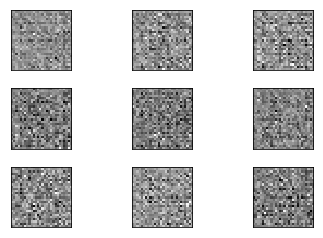

Epoach 500
Discriminator loss:  0.0167741
Generator loss: 7.5112
(9, 100)


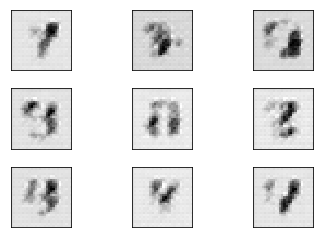

Epoach 1000
Discriminator loss:  0.100628
Generator loss: 5.62695
(9, 100)


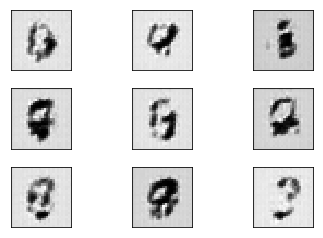

Epoach 1500
Discriminator loss:  0.331049
Generator loss: 5.74971
(9, 100)


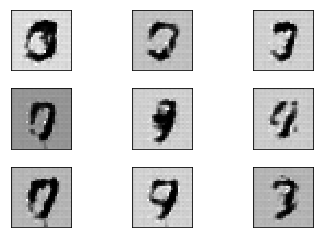

Epoach 2000
Discriminator loss:  0.0150868
Generator loss: 8.68033
(9, 100)


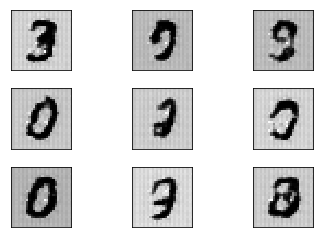

Epoach 2500
Discriminator loss:  0.0210796
Generator loss: 4.48669
(9, 100)


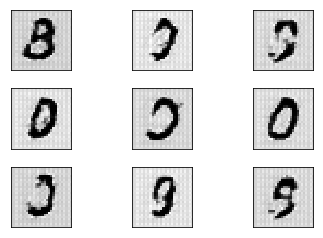

Epoach 3000
Discriminator loss:  0.0392664
Generator loss: 5.86135
(9, 100)


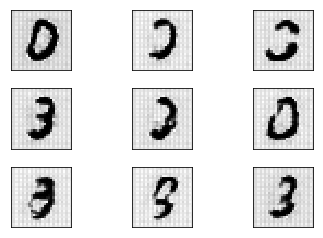

Epoach 3500
Discriminator loss:  0.300027
Generator loss: 9.76208
(9, 100)


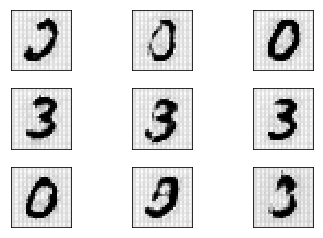

Epoach 4000
Discriminator loss:  0.0373339
Generator loss: 7.18562
(9, 100)


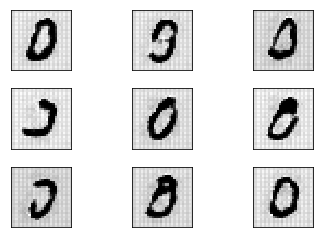

Epoach 4500
Discriminator loss:  0.0227799
Generator loss: 7.14583
(9, 100)


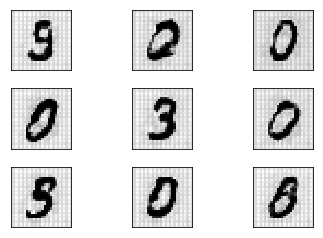

Epoach 5000
Discriminator loss:  0.0252604
Generator loss: 6.01284
(9, 100)


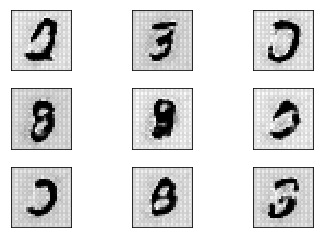

Epoach 5500
Discriminator loss:  0.279924
Generator loss: 12.9272
(9, 100)


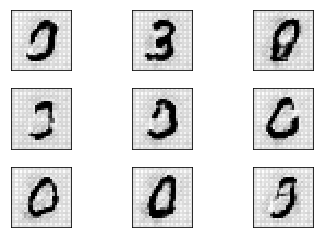

Epoach 6000
Discriminator loss:  0.021241
Generator loss: 8.11806
(9, 100)


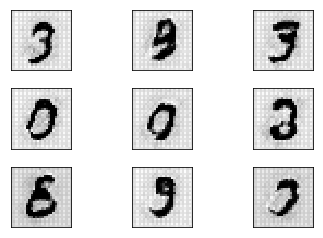

Epoach 6500
Discriminator loss:  0.00737118
Generator loss: 9.35173
(9, 100)


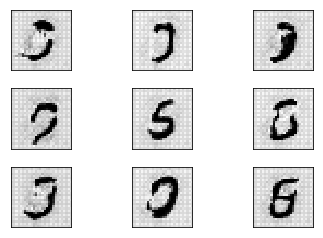

Epoach 7000
Discriminator loss:  0.0545359
Generator loss: 8.45545
(9, 100)


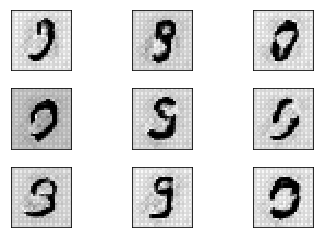

Epoach 7500
Discriminator loss:  0.000221752
Generator loss: 10.5918
(9, 100)


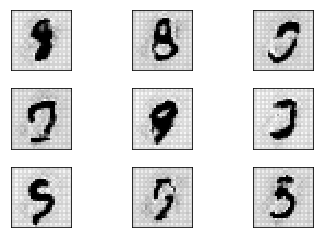

Epoach 8000
Discriminator loss:  0.0138664
Generator loss: 5.41232
(9, 100)


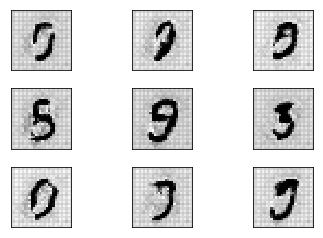

Epoach 8500
Discriminator loss:  0.00968643
Generator loss: 9.17483
(9, 100)


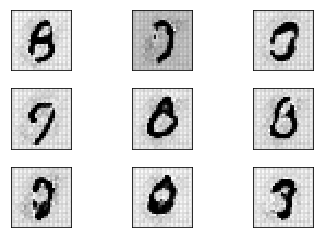

Epoach 9000
Discriminator loss:  0.0411545
Generator loss: 8.24193
(9, 100)


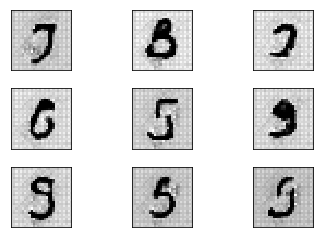

Epoach 9500
Discriminator loss:  0.0276292
Generator loss: 10.4419
(9, 100)


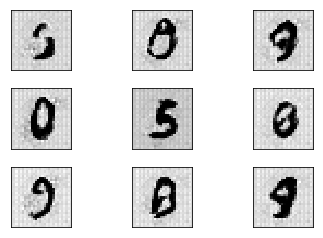

Epoach 10000
Discriminator loss:  0.0783007
Generator loss: 6.13089
(9, 100)


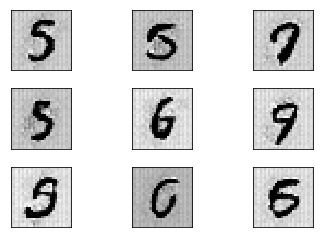

Epoach 10500
Discriminator loss:  0.0260414
Generator loss: 8.45801
(9, 100)


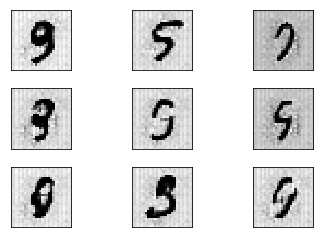

Epoach 11000
Discriminator loss:  0.0621712
Generator loss: 9.69079
(9, 100)


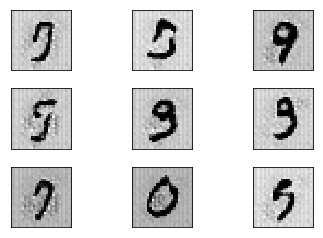

Epoach 11500
Discriminator loss:  0.00390166
Generator loss: 7.22353
(9, 100)


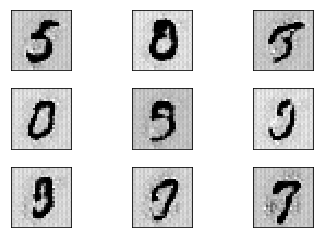

Epoach 12000
Discriminator loss:  0.00244482
Generator loss: 8.82417
(9, 100)


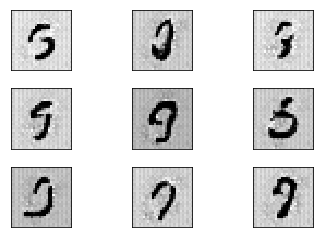

Epoach 12500
Discriminator loss:  0.0118059
Generator loss: 6.05779
(9, 100)


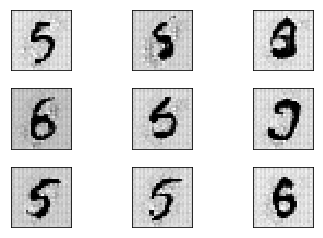

Epoach 13000
Discriminator loss:  0.0569717
Generator loss: 6.29773
(9, 100)


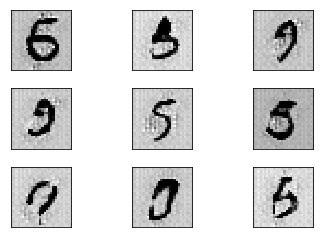

Epoach 13500
Discriminator loss:  0.00579558
Generator loss: 8.29506
(9, 100)


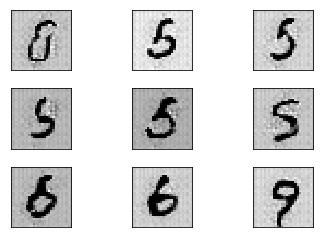

Epoach 14000
Discriminator loss:  0.213886
Generator loss: 8.08244
(9, 100)


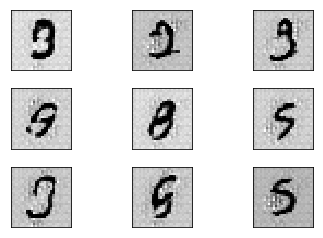

Epoach 14500
Discriminator loss:  0.0159864
Generator loss: 7.4538
(9, 100)


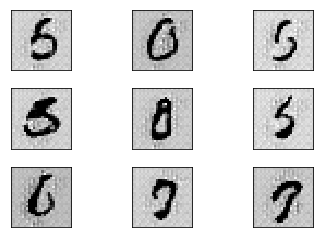

Epoach 15000
Discriminator loss:  0.00145718
Generator loss: 8.96027
(9, 100)


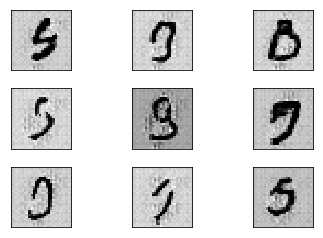

Epoach 15500
Discriminator loss:  0.203618
Generator loss: 7.21576
(9, 100)


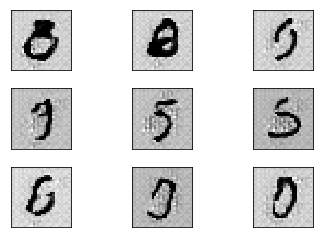

Epoach 16000
Discriminator loss:  0.0408516
Generator loss: 8.01925
(9, 100)


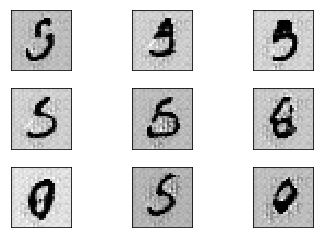

Epoach 16500
Discriminator loss:  0.00841119
Generator loss: 10.2415
(9, 100)


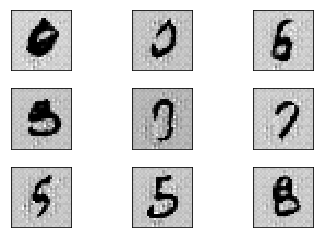

Epoach 17000
Discriminator loss:  0.0714653
Generator loss: 5.98146
(9, 100)


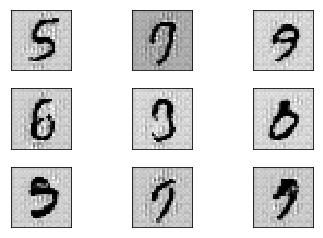

Epoach 17500
Discriminator loss:  0.0607396
Generator loss: 7.50237
(9, 100)


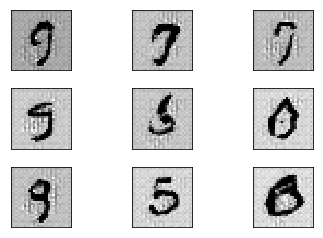

Epoach 18000
Discriminator loss:  0.0373408
Generator loss: 8.06943
(9, 100)


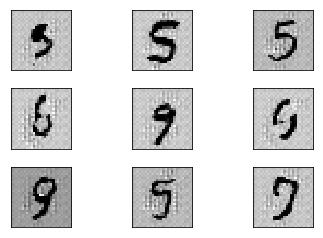

Epoach 18500
Discriminator loss:  0.000887198
Generator loss: 11.4763
(9, 100)


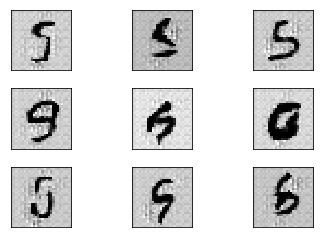

Epoach 19000
Discriminator loss:  0.00230791
Generator loss: 9.4444
(9, 100)


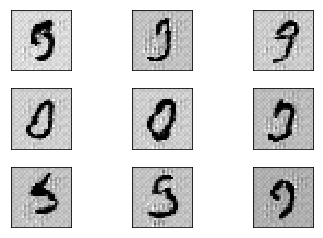

Epoach 19500
Discriminator loss:  0.164643
Generator loss: 8.87125
(9, 100)


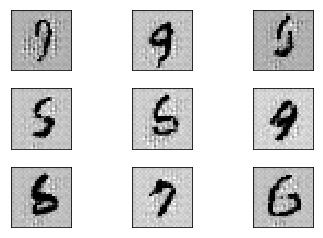

Epoach 20000
Discriminator loss:  0.00415638
Generator loss: 8.88909
(9, 100)


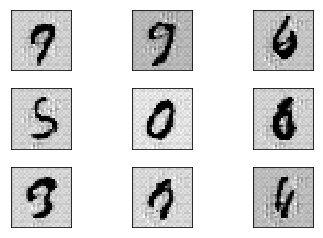

Epoach 20500
Discriminator loss:  0.00111488
Generator loss: 6.49162
(9, 100)


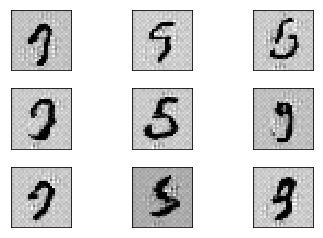

Epoach 21000
Discriminator loss:  0.000468825
Generator loss: 9.68954
(9, 100)


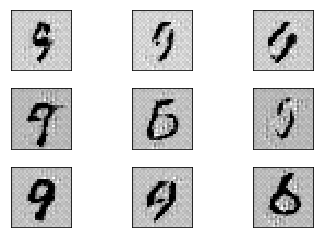

Epoach 21500
Discriminator loss:  0.00446146
Generator loss: 9.81269
(9, 100)


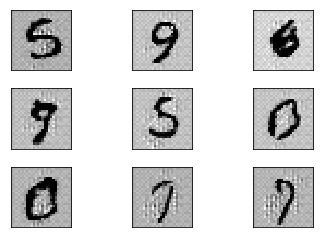

Epoach 22000
Discriminator loss:  0.00585673
Generator loss: 13.2426
(9, 100)


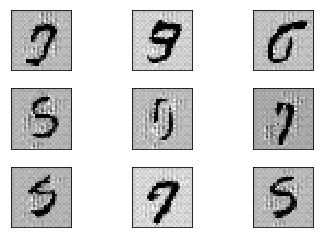

Epoach 22500
Discriminator loss:  0.00264516
Generator loss: 10.088
(9, 100)


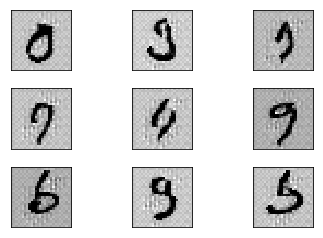

Epoach 23000
Discriminator loss:  0.00104743
Generator loss: 9.70791
(9, 100)


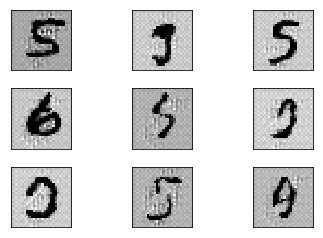

Epoach 23500
Discriminator loss:  0.0202405
Generator loss: 9.54922
(9, 100)


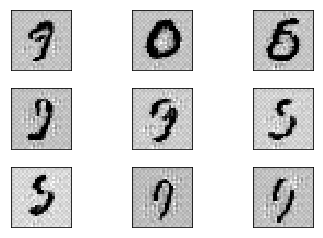

Epoach 24000
Discriminator loss:  0.00175139
Generator loss: 6.7729
(9, 100)


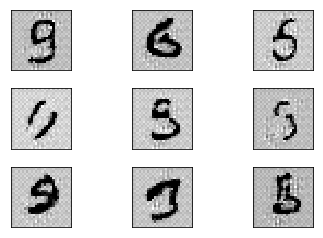

Epoach 24500
Discriminator loss:  0.00134658
Generator loss: 9.35149
(9, 100)


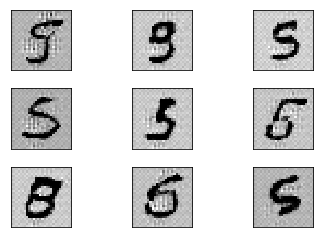

Epoach 25000
Discriminator loss:  0.000227985
Generator loss: 7.62756
(9, 100)


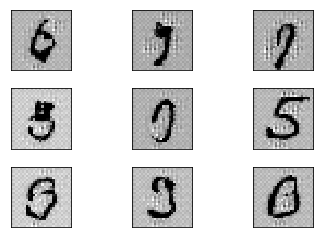

Epoach 25500
Discriminator loss:  0.434718
Generator loss: 9.52813
(9, 100)


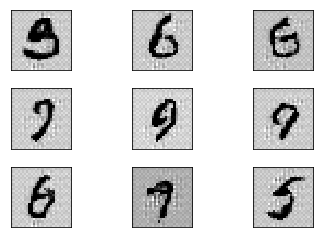

Epoach 26000
Discriminator loss:  0.000890522
Generator loss: 6.85638
(9, 100)


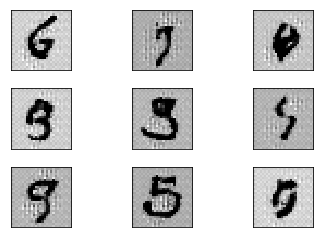

Epoach 26500
Discriminator loss:  0.0739633
Generator loss: 9.78901
(9, 100)


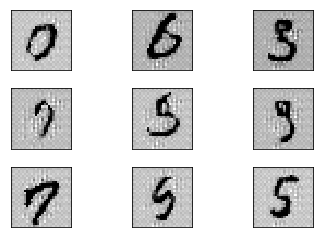

Epoach 27000
Discriminator loss:  0.00285331
Generator loss: 9.00415
(9, 100)


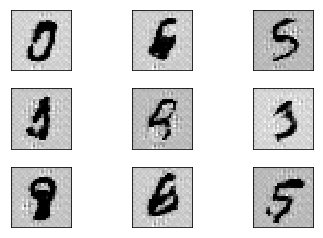

Epoach 27500
Discriminator loss:  0.000753226
Generator loss: 9.33752
(9, 100)


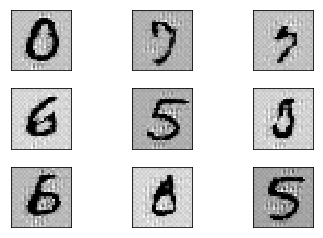

Epoach 28000
Discriminator loss:  0.0867565
Generator loss: 8.97322
(9, 100)


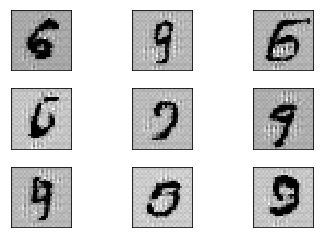

Epoach 28500
Discriminator loss:  0.00185221
Generator loss: 8.87964
(9, 100)


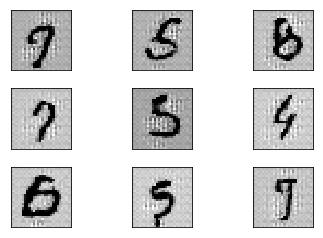

Epoach 29000
Discriminator loss:  0.00396639
Generator loss: 12.4422
(9, 100)


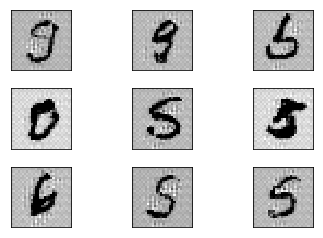

Epoach 29500
Discriminator loss:  0.00590417
Generator loss: 11.6418
(9, 100)


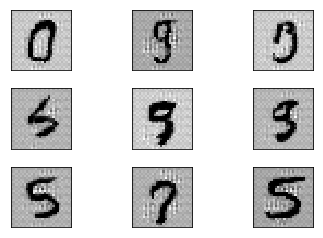

Epoach 30000
Discriminator loss:  0.000730843
Generator loss: 8.26612
(9, 100)


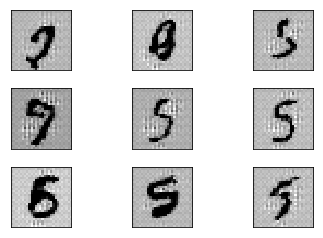

Epoach 30500
Discriminator loss:  0.0201719
Generator loss: 12.0571
(9, 100)


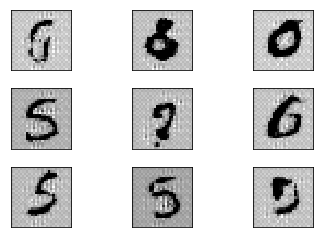

Epoach 31000
Discriminator loss:  0.00216872
Generator loss: 8.64111
(9, 100)


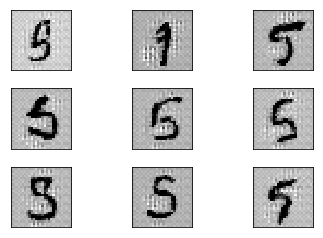

Epoach 31500
Discriminator loss:  0.0108458
Generator loss: 12.8491
(9, 100)


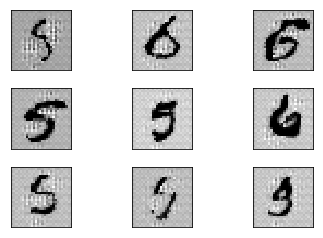

Epoach 32000
Discriminator loss:  0.00303199
Generator loss: 9.33339
(9, 100)


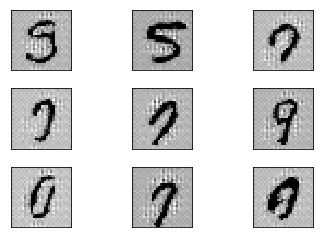

Epoach 32500
Discriminator loss:  0.0430336
Generator loss: 6.47321
(9, 100)


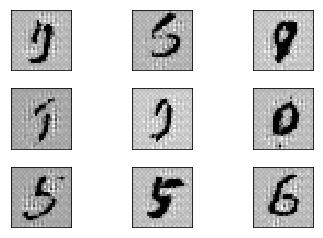

Epoach 33000
Discriminator loss:  0.00278216
Generator loss: 6.44006
(9, 100)


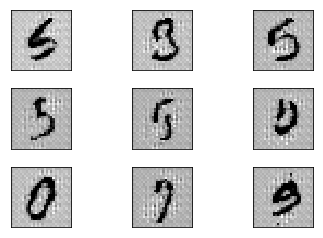

Epoach 33500
Discriminator loss:  0.00572229
Generator loss: 10.9465
(9, 100)


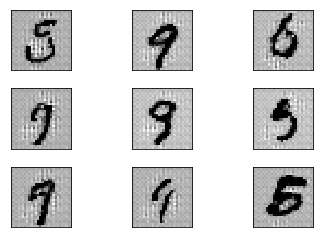

Epoach 34000
Discriminator loss:  0.0153254
Generator loss: 12.7854
(9, 100)


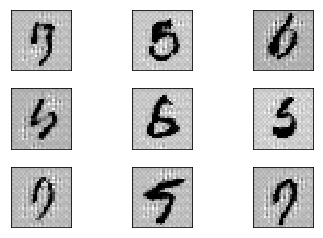

Epoach 34500
Discriminator loss:  0.00175708
Generator loss: 9.90632
(9, 100)


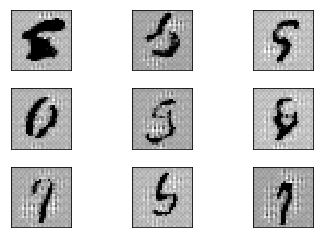

Epoach 35000
Discriminator loss:  0.000637649
Generator loss: 14.4291
(9, 100)


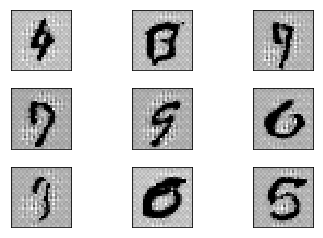

Epoach 35500
Discriminator loss:  0.019698
Generator loss: 13.7782
(9, 100)


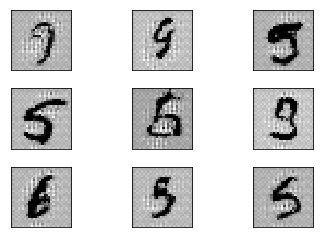

Epoach 36000
Discriminator loss:  0.0214258
Generator loss: 11.4103
(9, 100)


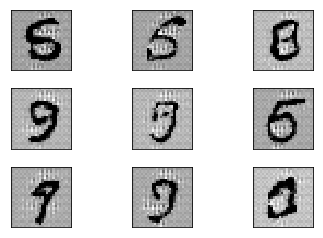

Epoach 36500
Discriminator loss:  0.00686283
Generator loss: 7.58684
(9, 100)


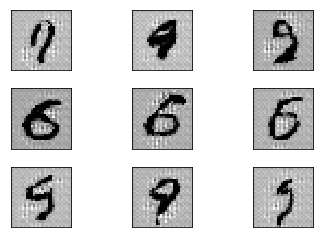

Epoach 37000
Discriminator loss:  0.000936066
Generator loss: 12.8522
(9, 100)


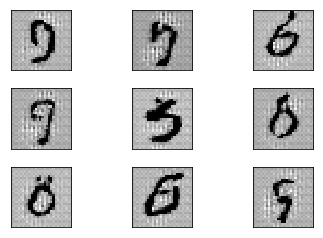

Epoach 37500
Discriminator loss:  0.0357865
Generator loss: 7.28951
(9, 100)


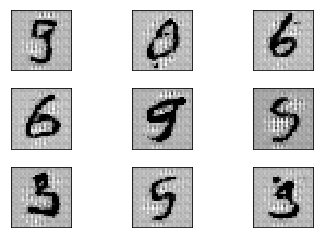

Epoach 38000
Discriminator loss:  0.0256763
Generator loss: 9.78951
(9, 100)


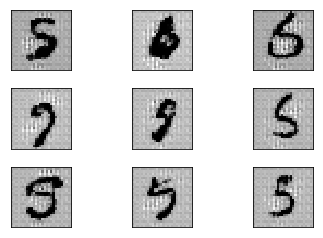

Epoach 38500
Discriminator loss:  8.84667e-05
Generator loss: 11.5273
(9, 100)


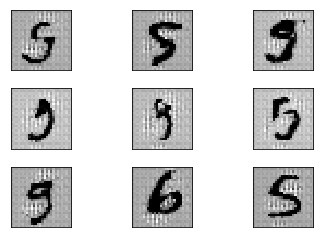

Epoach 39000
Discriminator loss:  0.000257903
Generator loss: 12.9067
(9, 100)


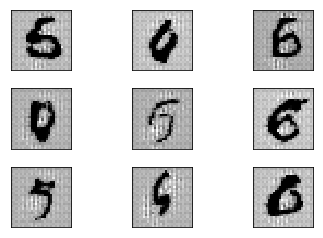

Epoach 39500
Discriminator loss:  0.000925358
Generator loss: 13.775
(9, 100)


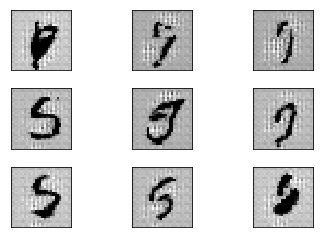

Epoach 40000
Discriminator loss:  0.00399579
Generator loss: 12.1429
(9, 100)


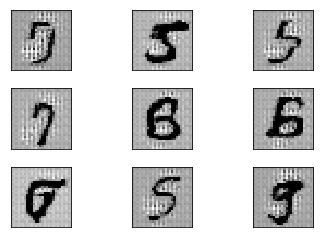

Epoach 40500
Discriminator loss:  0.000803841
Generator loss: 14.597
(9, 100)


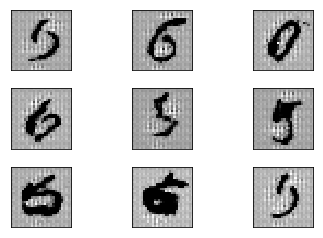

Epoach 41000
Discriminator loss:  0.000225285
Generator loss: 7.92139
(9, 100)


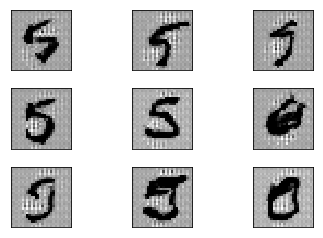

Epoach 41500
Discriminator loss:  9.15709e-05
Generator loss: 13.0536
(9, 100)


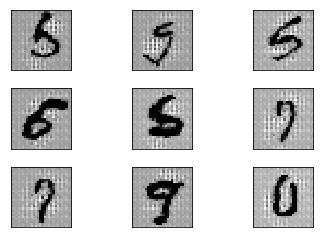

Epoach 42000
Discriminator loss:  0.0033631
Generator loss: 7.13757
(9, 100)


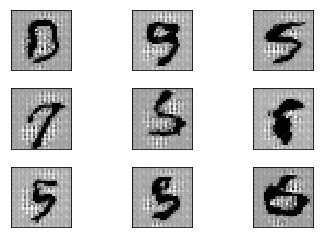

Epoach 42500
Discriminator loss:  5.82327e-05
Generator loss: 12.2546
(9, 100)


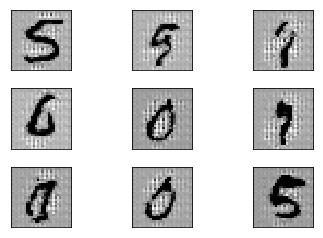

Epoach 43000
Discriminator loss:  0.00537712
Generator loss: 5.12869
(9, 100)


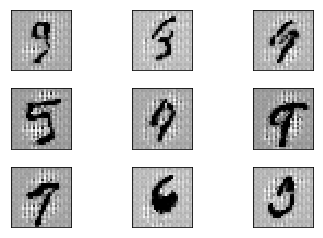

Epoach 43500
Discriminator loss:  0.0137026
Generator loss: 9.19373
(9, 100)


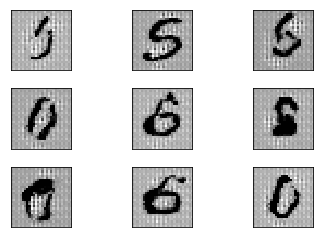

Epoach 44000
Discriminator loss:  0.122415
Generator loss: 11.3839
(9, 100)


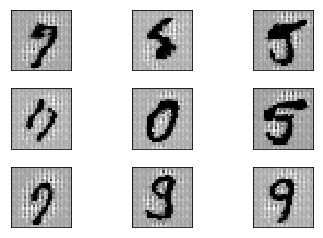

Epoach 44500
Discriminator loss:  4.59238e-05
Generator loss: 10.4386
(9, 100)


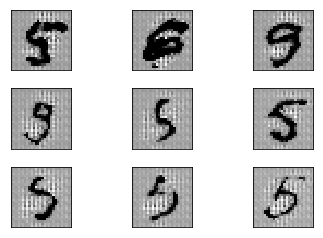

Epoach 45000
Discriminator loss:  0.000362088
Generator loss: 13.6022
(9, 100)


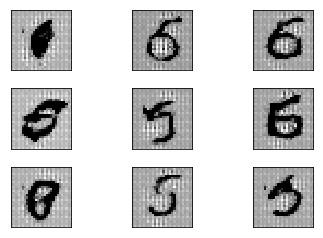

Epoach 45500
Discriminator loss:  0.0180782
Generator loss: 9.14598
(9, 100)


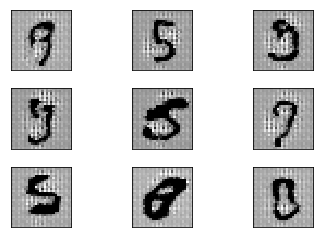

Epoach 46000
Discriminator loss:  0.00396412
Generator loss: 8.82173
(9, 100)


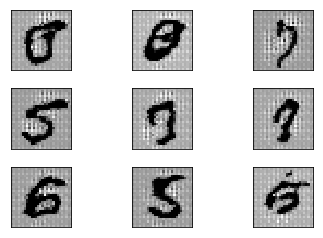

Epoach 46500
Discriminator loss:  0.000234425
Generator loss: 12.0212
(9, 100)


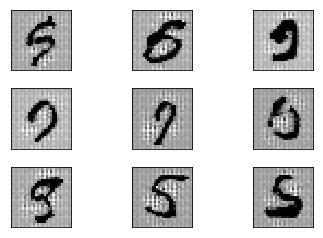

Epoach 47000
Discriminator loss:  4.92663e-05
Generator loss: 13.7764
(9, 100)


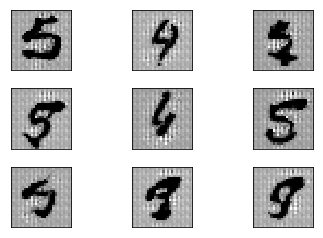

Epoach 47500
Discriminator loss:  0.221396
Generator loss: 7.78558
(9, 100)


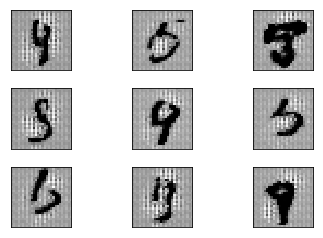

Epoach 48000
Discriminator loss:  7.9346e-05
Generator loss: 14.0749
(9, 100)


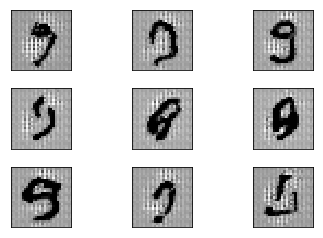

Epoach 48500
Discriminator loss:  0.070761
Generator loss: 9.69861
(9, 100)


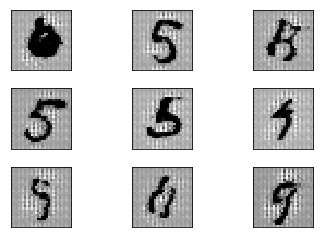

Epoach 49000
Discriminator loss:  0.0125874
Generator loss: 12.94
(9, 100)


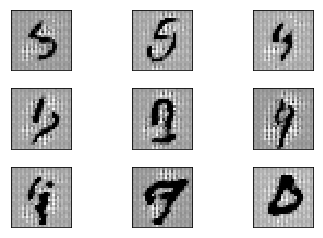

Epoach 49500
Discriminator loss:  0.000443297
Generator loss: 8.45013
(9, 100)


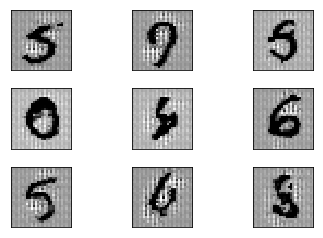

Epoach 50000
Discriminator loss:  0.0248306
Generator loss: 6.59279
(9, 100)


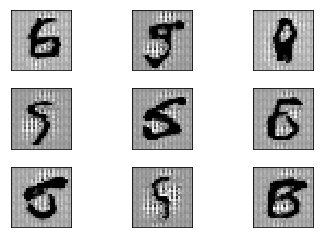

In [8]:
lr=0.001
with tf.name_scope("discriminator_train"):
    d_optimizer = tf.train.AdamOptimizer(learning_rate=lr)
    d_train_op = d_optimizer.minimize(d_loss, var_list=discriminator_variables) # note minimizing negative loss is the same as maximizing, tf dont have maximizing

with tf.name_scope("generator_train"):
    g_optimizer = tf.train.AdamOptimizer(learning_rate=lr)
    g_train_op = g_optimizer.minimize(g_loss,var_list=generator_variables)


## Start graph computations and algorithm

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(epoach+1):
    x_train,y_train = mnist.train.next_batch(batch_size)
    
    #print(y_one_hot)
    #first discriminator
    _, d_loss_value = sess.run([d_train_op, d_loss], feed_dict={X: x_train, isTraining:True , Z: ut.random_Z(batch_size,n=z_dimention)})
    #second generator
    _, g_loss_value = sess.run([g_train_op, g_loss], feed_dict={Z: ut.random_Z(batch_size,n=z_dimention),isTraining:True})

    if i%500 == 0:
        print("Epoach",i)
        print("Discriminator loss: ",d_loss_value)
        print("Generator loss:",g_loss_value)
        #print("D_sample",d_sample)
        #print("G_sample",g_sample)
        
        #visual progress of training
        z_new = ut.random_Z(9,n=z_dimention)
        print(z_new.shape)
        generated_images = generated_sample.eval(session=sess,feed_dict={Z: z_new})
        ut.plot_mnist_images(generated_images)

### Testing the classifier

In [9]:
sess.close()